# SVHN Inference
This notebook demonstrates the load, prep, and model inference part of the ML loop.
MZ 2022

In [3]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchmetrics import F1Score, ConfusionMatrix, MatthewsCorrCoef
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image


### 1 - Define support functions
+ dataset
+ model
+ predict function

In [4]:
## make a callable dataset using pytorch tools that interfaces with Dataloader and Transforms
class svhn_dataset():
    """ pytorch-friendly dataset class for svhn
    """
    def __init__(self, X, y, transforms = None):
        self.X = X
        self.y = y.squeeze() 
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        #convert to PIL image for transforms
        image = Image.fromarray(self.X[index,...])
        label = self.y[index]

        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, int(label)

In [5]:
# deep CNN. Lets do (input)-(3x(conv,pool,drop)layers)-(dense_out)
class cnn(nn.Module):
    """
        Define cnn model for SVHN
    """
    def __init__(self, input_size, num_layers, n_feat_l1=16, num_classes=10, RGB=True, dropout_probability=0.2, kernel_size=3, stride=1, pad=1):
        
        super(cnn, self).__init__()
        # variables
        self.input_size = input_size
        self.num_layers = num_layers
        self.n_feat_l1 = n_feat_l1
        self.num_classes = num_classes
        self.dropout_probability = dropout_probability
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        if RGB:
            input_channels=3
        else:
            input_channels=1

        #define model layers
        self.in_features = np.arange(self.n_feat_l1,self.n_feat_l1*(2+self.num_layers), self.n_feat_l1)

        self.input_layer = nn.Conv2d(in_channels=input_channels,
            out_channels=n_feat_l1,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.pad)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.drop = nn.Dropout2d(p=self.dropout_probability)

        self.fc = nn.Linear(int(self.in_features[-1]*(self.input_size[0]/2**self.num_layers)), out_features=num_classes)

        self.sequence = nn.Sequential()
        for l in range(self.num_layers):
            new = nn.Sequential(
                nn.Conv2d(in_channels=self.in_features[l],
                    out_channels=self.in_features[l+1],
                    kernel_size=self.kernel_size,
                    stride=self.stride,
                    padding=self.pad),
                nn.MaxPool2d(kernel_size=2), 
                nn.Dropout2d(p=dropout_probability),
                nn.ReLU()
            )
            self.sequence.append(new)
        
    def forward(self,x):

        x = F.relu(self.pool2(self.input_layer(x)))
        x = self.sequence(x)
        x = x.view(-1, int(self.in_features[-1]*(self.input_size[0]/2**self.num_layers))) #flatten before fc
        x = self.fc(x)
        x = F.log_softmax(x,dim=1)

        return x

In [13]:
def predict(model, images):
    """Predicts which numbers are in the batch of images.
    Args:
        model (_type_): pytorch model
        device (_type_): target device
        validation_loader (_type_): data loader
        loss_metric (_type_): loss metric object

    Returns:
        predicted_labels(tensor): predicted labels
    """
    model.eval()

    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    with torch.no_grad():

        images = images.to(device=device)
        
        output = model(images)

        # get predicted labels 
        _, predicted_labels = torch.max(output.data, 1)

    return predicted_labels

### 2 - Roll the test
+ load data
+ load model

In [47]:
# paths
path_to_data = 'data/test_32x32.mat'
path_to_model = 'models/svhn_model_2022_09_19_1302_e29.pt' #best model

# Model initialization and load from state_dict
model = cnn(input_size=(32,32),num_layers=3,n_feat_l1=32, num_classes=10)
model.load_state_dict(torch.load(path_to_model))

# load dataset
test_data = scipy.io.loadmat(file_name=path_to_data)

# reshape X into NCHW from HWCN. pytorch likes NCHW for transforms
X = test_data['X']
X = np.transpose(X, axes=(3,0,1,2)) # NHWC order
y = test_data['y']
y[y==10] = 0 #swap 10->0

# Define image transforms
image_transforms = transforms.Compose([
    transforms.ToTensor(), #get to pytorch tensor from PIL image
]) 
test_dataset = svhn_dataset(X=X, y=y, transforms=image_transforms)
batch_size = 16
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [48]:
images, labels = next(iter(test_dataloader))
predicted_labels = predict(model, images)

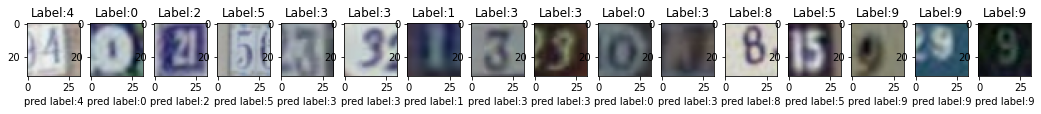

In [50]:
## visualize the results: Example images and pred/actual labels
fig = plt.figure(figsize=(batch_size+2,1+batch_size//2))
for r in range(0,batch_size):
    image = images[r,...]
    
    plt.subplot(1,batch_size,r+1)
    plt.imshow(np.transpose(image,axes=(1,2,0))) #get back from pytorch ordering to something plt likes
    plt.xlabel(f'pred label:{predicted_labels[r]}')
    plt.title(f'Label:{labels[r]}')
plt.show()